In [1]:
# ✅ 1. Imports (except Inception-specific ones)
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torchvision import transforms, models
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
import time
from tqdm import tqdm
import glob


In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
class LabelSmoothingCrossEntropy(nn.Module):
    """Label smoothing cross entropy loss."""

    def __init__(self, smoothing: float = 0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        log_prob = F.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss


In [4]:
class BreakHisDataset(Dataset):
    """BreakHis dataset class for tumor classification."""

    def __init__(self, image_paths: List[str], labels: List[int],
                 transform: Optional[transforms.Compose] = None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
class EarlyStopping:
    """Early stopping utility."""

    def __init__(self, patience: int = 10, min_delta: float = 0.001,
                 mode: str = 'min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_score: float):
        if self.best_score is None:
            self.best_score = val_score
        elif self.mode == 'min':
            if val_score < self.best_score - self.min_delta:
                self.best_score = val_score
                self.counter = 0
            else:
                self.counter += 1
        else:  # mode == 'max'
            if val_score > self.best_score + self.min_delta:
                self.best_score = val_score
                self.counter = 0
            else:
                self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True


In [6]:
class MetricsCalculator:
    """Utility class for calculating classification metrics."""

    @staticmethod
    def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray,
                         y_pred_proba: np.ndarray) -> Dict[str, float]:
        """Calculate all classification metrics."""

        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='binary')
        recall = recall_score(y_true, y_pred, average='binary')
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        f1 = f1_score(y_true, y_pred, average='binary')
        auc_roc = roc_auc_score(y_true, y_pred_proba)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'f1': f1,
            'auc_roc': auc_roc,
            'confusion_matrix': cm
        }

    @staticmethod
    def plot_confusion_matrix(cm: np.ndarray, title: str = "Confusion Matrix"):
        """Plot confusion matrix heatmap."""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Benign', 'Malignant'],
                   yticklabels=['Benign', 'Malignant'])
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

In [11]:
# Modified data transforms in the BreakHisTrainer class
class BreakHisTrainer:
    # ... (keep all existing methods except __init__)

    def __init__(self, data_dir: str, batch_size: int = 32,
                 num_workers: int = 4, device: str = 'cuda'):
        self.data_dir = Path(data_dir)
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

        # Results storage
        self.results = {}

        # Data transforms - Updated for EfficientNet-B3 (300x300 input)
        self.train_transforms = transforms.Compose([
            transforms.Resize(320),  # Slightly larger than 300 for cropping
            transforms.CenterCrop(300),  # EfficientNet-B3 works well with 300x300
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2,
                                 saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Add slight translation
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        self.val_transforms = transforms.Compose([
            transforms.Resize(320),
            transforms.CenterCrop(300),  # EfficientNet-B3 input size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def parse_dataset(self) -> Dict[str, List]:
        print("Parsing BreakHis dataset...")
        possible_paths = [
            os.path.join(self.data_dir, 'BreaKHis_v1/BreaKHis_v1/histology_slides/breast/**/*.png'),
            os.path.join(self.data_dir, 'BreaKHis_v1/histology_slides/breast/**/*.png'),
            os.path.join(self.data_dir, 'histology_slides/breast/**/*.png'),
            os.path.join(self.data_dir, '**/*.png'),
        ]

        breast_img_paths = []
        for pattern in possible_paths:
            breast_img_paths = glob.glob(pattern, recursive=True)
            if breast_img_paths:
                print(f"Found images using pattern: {pattern}")
                break

        if not breast_img_paths:
            raise FileNotFoundError(f"No PNG files found in {self.data_dir}.")

        print(f"Found {len(breast_img_paths)} image files")

        data_info = {'image_paths': [], 'labels': [], 'magnifications': [], 'patient_ids': []}

        for img_path in breast_img_paths:
            try:
                path_parts = img_path.split(os.sep)
                if 'benign' in img_path.lower():
                    label = 0
                elif 'malignant' in img_path.lower():
                    label = 1
                else:
                    continue

                filename = os.path.basename(img_path)

                if '-40-' in filename:
                    mag = '40X'
                elif '-100-' in filename:
                    mag = '100X'
                elif '-200-' in filename:
                    mag = '200X'
                elif '-400-' in filename:
                    mag = '400X'
                else:
                    continue

                parts = filename.split('-')
                if len(parts) >= 3:
                    patient_id = '-'.join(parts[:3])
                else:
                    patient_id = filename.split('.')[0]

                data_info['image_paths'].append(img_path)
                data_info['labels'].append(label)
                data_info['magnifications'].append(mag)
                data_info['patient_ids'].append(patient_id)

            except Exception as e:
                print(f"Error processing {img_path}: {e}")

        print(f"Successfully parsed {len(data_info['image_paths'])} images")
        print(f"Benign: {len([l for l in data_info['labels'] if l == 0])}")
        print(f"Malignant: {len([l for l in data_info['labels'] if l == 1])}")
        print(f"Magnifications: {set(data_info['magnifications'])}")
        print(f"Unique patients: {len(set(data_info['patient_ids']))}")

        return data_info

    def create_patient_splits(self, data_info: Dict, test_size: float = 0.2, val_size: float = 0.2) -> Dict[str, Dict]:
        df = pd.DataFrame(data_info)
        patient_labels = df.groupby('patient_ids')['labels'].first().reset_index()

        train_val_patients, test_patients = train_test_split(
            patient_labels['patient_ids'].tolist(),
            test_size=test_size,
            stratify=patient_labels['labels'].tolist(),
            random_state=42
        )

        train_val_labels = patient_labels[patient_labels['patient_ids'].isin(train_val_patients)]['labels'].tolist()
        train_patients, val_patients = train_test_split(
            train_val_patients,
            test_size=val_size / (1 - test_size),
            stratify=train_val_labels,
            random_state=42
        )

        magnifications = ['40X', '100X', '200X', '400X', 'All']
        splits = {}

        for mag in magnifications:
            if mag == 'All':
                mag_mask = pd.Series([True] * len(df))
            else:
                mag_mask = df['magnifications'] == mag

            mag_df = df[mag_mask]

            train_mask = mag_df['patient_ids'].isin(train_patients)
            val_mask = mag_df['patient_ids'].isin(val_patients)
            test_mask = mag_df['patient_ids'].isin(test_patients)

            splits[mag] = {
                'train': {
                    'image_paths': mag_df[train_mask]['image_paths'].tolist(),
                    'labels': mag_df[train_mask]['labels'].tolist()
                },
                'val': {
                    'image_paths': mag_df[val_mask]['image_paths'].tolist(),
                    'labels': mag_df[val_mask]['labels'].tolist()
                },
                'test': {
                    'image_paths': mag_df[test_mask]['image_paths'].tolist(),
                    'labels': mag_df[test_mask]['labels'].tolist()
                }
            }

            print(f"\n{mag} - Train: {len(splits[mag]['train']['labels'])}, "
                  f"Val: {len(splits[mag]['val']['labels'])}, "
                  f"Test: {len(splits[mag]['test']['labels'])}")

        return splits

    def create_data_loaders(self, splits: Dict, magnification: str) -> Dict[str, DataLoader]:
        split_data = splits[magnification]

        train_dataset = BreakHisDataset(
            split_data['train']['image_paths'],
            split_data['train']['labels'],
            self.train_transforms
        )

        val_dataset = BreakHisDataset(
            split_data['val']['image_paths'],
            split_data['val']['labels'],
            self.val_transforms
        )

        test_dataset = BreakHisDataset(
            split_data['test']['image_paths'],
            split_data['test']['labels'],
            self.val_transforms
        )

        train_labels = split_data['train']['labels']
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(train_labels),
            y=train_labels
        )

        sample_weights = [class_weights[label] for label in train_labels]
        sampler = WeightedRandomSampler(weights=sample_weights,
                                        num_samples=len(sample_weights),
                                        replacement=True)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size,
                                  sampler=sampler, num_workers=self.num_workers,
                                  pin_memory=True)

        val_loader = DataLoader(val_dataset, batch_size=self.batch_size,
                                shuffle=False, num_workers=self.num_workers,
                                pin_memory=True)

        test_loader = DataLoader(test_dataset, batch_size=self.batch_size,
                                 shuffle=False, num_workers=self.num_workers,
                                 pin_memory=True)

        return {'train': train_loader, 'val': val_loader, 'test': test_loader}


    # Modified train_epoch method to handle simpler EfficientNet output
    def train_epoch(self, model: nn.Module, train_loader: DataLoader,
                   criterion: nn.Module, optimizer: torch.optim.Optimizer) -> float:
        """Train for one epoch."""
        model.train()
        total_loss = 0.0

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc="Training")):
            images, labels = images.to(self.device), labels.to(self.device)

            optimizer.zero_grad()

            # EfficientNet has simple output (no auxiliary outputs)
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(train_loader)

    # Modified validate_epoch method
    def validate_epoch(self, model: nn.Module, val_loader: DataLoader,
                      criterion: nn.Module) -> Tuple[float, float]:
        """Validate for one epoch."""
        model.eval()
        total_loss = 0.0
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(self.device), labels.to(self.device)

                # EfficientNet has simple output
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                probs = F.softmax(outputs, dim=1)
                preds = outputs.argmax(dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of malignant

        avg_loss = total_loss / len(val_loader)
        auc_roc = roc_auc_score(all_labels, all_probs)

        return avg_loss, auc_roc

    # Modified test_model method
    def test_model(self, model: nn.Module, test_loader: DataLoader) -> Dict[str, float]:
        """Test the model and return metrics."""
        model.eval()
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing"):
                images, labels = images.to(self.device), labels.to(self.device)

                # EfficientNet has simple output
                outputs = model(images)

                probs = F.softmax(outputs, dim=1)
                preds = outputs.argmax(dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy())

        return MetricsCalculator.calculate_metrics(
            np.array(all_labels),
            np.array(all_preds),
            np.array(all_probs)
        )

    # Modified train_magnification method with updated print statements
    def train_magnification(self, splits: Dict, magnification: str,
                          epochs: int = 100) -> Dict[str, float]:
        """Train model for a specific magnification."""

        print(f"\n{'='*60}")
        print(f"Training on {magnification} magnification with EfficientNet-B3")
        print(f"{'='*60}")

        # Create data loaders
        data_loaders = self.create_data_loaders(splits, magnification)

        # Initialize model
        model = TumorClassifier(num_classes=2, dropout_rate=0.5)
        model.to(self.device)

        # Loss function
        criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

        # Phase 1: Train classifier head with frozen backbone
        print("\nPhase 1: Training classifier head (frozen backbone)")
        model.freeze_backbone()

        optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=0.001, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                                    patience=5, verbose=True)
        early_stopping = EarlyStopping(patience=10, mode='max')

        best_auc = 0.0
        best_model_state = None

        for epoch in range(epochs // 2):
            # Training
            train_loss = self.train_epoch(model, data_loaders['train'],
                                        criterion, optimizer)

            # Validation
            val_loss, val_auc = self.validate_epoch(model, data_loaders['val'],
                                                  criterion)

            scheduler.step(val_auc)
            early_stopping(val_auc)

            print(f"Epoch {epoch+1:3d}: Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

            # Save best model
            if val_auc > best_auc:
                best_auc = val_auc
                best_model_state = model.state_dict().copy()

            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Load best model from Phase 1
        model.load_state_dict(best_model_state)

        # Phase 2: Fine-tune with unfrozen last conv layers
        print("\nPhase 2: Fine-tuning with unfrozen last conv layers")
        model.unfreeze_last_conv_layers(num_layers=4)

        optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=0.0001, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                                    patience=5, verbose=True)
        early_stopping = EarlyStopping(patience=10, mode='max')

        for epoch in range(epochs // 2):
            # Training
            train_loss = self.train_epoch(model, data_loaders['train'],
                                        criterion, optimizer)

            # Validation
            val_loss, val_auc = self.validate_epoch(model, data_loaders['val'],
                                                  criterion)

            scheduler.step(val_auc)
            early_stopping(val_auc)

            print(f"Epoch {epoch+1:3d}: Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

            # Save best model
            if val_auc > best_auc:
                best_auc = val_auc
                best_model_state = model.state_dict().copy()

            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Load best model and test
        model.load_state_dict(best_model_state)
        test_metrics = self.test_model(model, data_loaders['test'])

        print(f"\nBest validation AUC: {best_auc:.4f}")
        print(f"Test metrics:")
        for metric, value in test_metrics.items():
            if metric != 'confusion_matrix':
                print(f"  {metric}: {value:.4f}")

        # Plot confusion matrix
        cm = test_metrics['confusion_matrix']
        MetricsCalculator.plot_confusion_matrix(cm, f"Confusion Matrix - {magnification} (EfficientNet-B3)")

        return test_metrics

    def run_all_experiments(self, data_dir: str) -> pd.DataFrame:
        """Run experiments for all magnifications."""

        print("Starting BreakHis tumor classification experiments with EfficientNet-B3...")

        # Parse dataset
        data_info = self.parse_dataset()

        # Create patient-level splits
        splits = self.create_patient_splits(data_info)

        # Run experiments for each magnification
        magnifications = ['40X', '100X', '200X', '400X', 'All']
        results = []

        for mag in magnifications:
            print(f"\nStarting experiment for {mag}...")
            metrics = self.train_magnification(splits, mag)

            result = {
                'Magnification': mag,
                'Accuracy': metrics['accuracy'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'Specificity': metrics['specificity'],
                'F1': metrics['f1'],
                'AUC-ROC': metrics['auc_roc']
            }
            results.append(result)

            # Store confusion matrix separately
            self.results[mag] = {
                'metrics': result,
                'confusion_matrix': metrics['confusion_matrix']
            }

        # Create results DataFrame
        results_df = pd.DataFrame(results)

        # Display results table
        print("\n" + "="*80)
        print("FINAL RESULTS TABLE - EfficientNet-B3")
        print("="*80)
        print(results_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

        return results_df

In [12]:
class TumorClassifier(nn.Module):
    """EfficientNet-B3-based tumor classifier."""

    def __init__(self, num_classes: int = 2, dropout_rate: float = 0.5):
        super().__init__()

        # Load pretrained EfficientNet-B3
        self.backbone = efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)

        # Get the number of features from the classifier
        num_features = self.backbone.classifier[1].in_features

        # Replace the final classifier with a more robust one
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate, inplace=True),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, num_classes)
        )

        # Initialize classifier weights
        self._init_classifier_weights()

    def _init_classifier_weights(self):
        """Initialize classifier weights."""
        for m in self.backbone.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # EfficientNet has a simple forward pass (no auxiliary outputs)
        return self.backbone(x)

    def freeze_backbone(self):
        """Freeze backbone parameters except final classifier."""
        for name, param in self.backbone.named_parameters():
            if 'classifier' not in name:
                param.requires_grad = False

    def unfreeze_last_conv_layers(self, num_layers: int = 4):
        """Unfreeze last few layers of EfficientNet-B3."""
        # EfficientNet-B3 has features organized in blocks
        # We'll unfreeze the last few blocks in the features section

        # Get all parameters in the features section
        feature_params = list(self.backbone.features.named_parameters())

        # Calculate how many parameters to unfreeze from the end
        # EfficientNet has many small layers, so we unfreeze more parameters
        total_params = len(feature_params)
        params_to_unfreeze = min(num_layers * 10, total_params)  # Unfreeze more layers

        # Unfreeze the last N parameters
        for name, param in feature_params[-params_to_unfreeze:]:
            param.requires_grad = True


In [13]:
# Modified main function
def main():
    """Main function to run the experiments."""

    # Download dataset using kagglehub
    import kagglehub

    # Download dataset
    path = kagglehub.dataset_download("ambarish/breakhis")
    print("Path to dataset files:", path)

    # Configuration
    DATA_DIR = path  # Use the downloaded path
    BATCH_SIZE = 32
    NUM_WORKERS = 4
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    print(f"Using device: {DEVICE}")
    print("Using EfficientNet-B3 backbone")

    # Initialize trainer
    trainer = BreakHisTrainer(
        data_dir=DATA_DIR,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        device=DEVICE
    )

    # Run all experiments
    results_df = trainer.run_all_experiments(DATA_DIR)

    # Save results
    results_df.to_csv('breakhis_efficientnet_b3_results.csv', index=False)
    print("\nResults saved to 'breakhis_efficientnet_b3_results.csv'")

    # Display final summary
    print("\n" + "="*80)
    print("EXPERIMENT SUMMARY - EfficientNet-B3")
    print("="*80)
    print(f"Average Accuracy: {results_df['Accuracy'].mean():.4f}")
    print(f"Average AUC-ROC: {results_df['AUC-ROC'].mean():.4f}")
    print(f"Best performing magnification: {results_df.loc[results_df['Accuracy'].idxmax(), 'Magnification']}")

    return results_df

Path to dataset files: /kaggle/input/breakhis
Using device: cuda
Using EfficientNet-B3 backbone
Starting BreakHis tumor classification experiments with EfficientNet-B3...
Parsing BreakHis dataset...
Found images using pattern: /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/**/*.png
Found 7909 image files
Successfully parsed 7909 images
Benign: 2480
Malignant: 5429
Magnifications: {'400X', '40X', '200X', '100X'}
Unique patients: 82

40X - Train: 1172, Val: 382, Test: 441

100X - Train: 1201, Val: 403, Test: 477

200X - Train: 1188, Val: 382, Test: 443

400X - Train: 1059, Val: 367, Test: 394

All - Train: 4620, Val: 1534, Test: 1755

Starting experiment for 40X...

Training on 40X magnification with EfficientNet-B3


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 208MB/s]



Phase 1: Training classifier head (frozen backbone)


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.68it/s]


Epoch   1: Train Loss: 0.6088, Val Loss: 0.6175, Val AUC: 0.7756


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Epoch   2: Train Loss: 0.5410, Val Loss: 0.6478, Val AUC: 0.8211


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Epoch   3: Train Loss: 0.5262, Val Loss: 0.6069, Val AUC: 0.8121


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Epoch   4: Train Loss: 0.5170, Val Loss: 0.5968, Val AUC: 0.8573


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Epoch   5: Train Loss: 0.5171, Val Loss: 0.5765, Val AUC: 0.8208


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Epoch   6: Train Loss: 0.5052, Val Loss: 0.5806, Val AUC: 0.8585


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]


Epoch   7: Train Loss: 0.4939, Val Loss: 0.6486, Val AUC: 0.8248


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


Epoch   8: Train Loss: 0.4892, Val Loss: 0.6159, Val AUC: 0.8490


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Epoch   9: Train Loss: 0.4819, Val Loss: 0.5671, Val AUC: 0.8264


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Epoch  10: Train Loss: 0.4860, Val Loss: 0.6500, Val AUC: 0.8552


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]


Epoch  11: Train Loss: 0.4821, Val Loss: 0.5631, Val AUC: 0.8585


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Epoch  12: Train Loss: 0.4751, Val Loss: 0.5642, Val AUC: 0.8394


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Epoch  13: Train Loss: 0.4761, Val Loss: 0.5834, Val AUC: 0.8291


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]


Epoch  14: Train Loss: 0.4629, Val Loss: 0.6052, Val AUC: 0.8191


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]


Epoch  15: Train Loss: 0.4624, Val Loss: 0.5935, Val AUC: 0.8333


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Epoch  16: Train Loss: 0.4592, Val Loss: 0.6139, Val AUC: 0.8283
Early stopping at epoch 16

Phase 2: Fine-tuning with unfrozen last conv layers


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.69it/s]


Epoch   1: Train Loss: 0.4663, Val Loss: 0.6055, Val AUC: 0.8450


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Epoch   2: Train Loss: 0.4415, Val Loss: 0.5788, Val AUC: 0.8401


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Epoch   3: Train Loss: 0.4189, Val Loss: 0.5815, Val AUC: 0.8499


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


Epoch   4: Train Loss: 0.4254, Val Loss: 0.5750, Val AUC: 0.8422


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Epoch   5: Train Loss: 0.4091, Val Loss: 0.5450, Val AUC: 0.8493


Validation: 100%|██████████| 12/12 [00:06<00:00,  2.00it/s]


Epoch   6: Train Loss: 0.4054, Val Loss: 0.5600, Val AUC: 0.8634


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


Epoch   7: Train Loss: 0.4064, Val Loss: 0.5550, Val AUC: 0.8659


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.70it/s]


Epoch   8: Train Loss: 0.4036, Val Loss: 0.5308, Val AUC: 0.8835


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


Epoch   9: Train Loss: 0.3931, Val Loss: 0.5144, Val AUC: 0.8896


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


Epoch  10: Train Loss: 0.3915, Val Loss: 0.5360, Val AUC: 0.8814


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Epoch  11: Train Loss: 0.3930, Val Loss: 0.5323, Val AUC: 0.8766


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.01it/s]


Epoch  12: Train Loss: 0.3992, Val Loss: 0.5308, Val AUC: 0.8769


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.98it/s]


Epoch  13: Train Loss: 0.3819, Val Loss: 0.5404, Val AUC: 0.8709


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]


Epoch  14: Train Loss: 0.3753, Val Loss: 0.5288, Val AUC: 0.8771


Validation: 100%|██████████| 12/12 [00:06<00:00,  2.00it/s]


Epoch  15: Train Loss: 0.3735, Val Loss: 0.5240, Val AUC: 0.8921


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Epoch  16: Train Loss: 0.3845, Val Loss: 0.5252, Val AUC: 0.8962


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Epoch  17: Train Loss: 0.3817, Val Loss: 0.5250, Val AUC: 0.8795


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.01it/s]


Epoch  18: Train Loss: 0.3767, Val Loss: 0.5201, Val AUC: 0.8765


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


Epoch  19: Train Loss: 0.3808, Val Loss: 0.5132, Val AUC: 0.8855


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]


Epoch  20: Train Loss: 0.3769, Val Loss: 0.5105, Val AUC: 0.8907


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Epoch  21: Train Loss: 0.3680, Val Loss: 0.5122, Val AUC: 0.8950


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Epoch  22: Train Loss: 0.3636, Val Loss: 0.5185, Val AUC: 0.8846


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


Epoch  23: Train Loss: 0.3684, Val Loss: 0.5124, Val AUC: 0.8869


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


Epoch  24: Train Loss: 0.3647, Val Loss: 0.5133, Val AUC: 0.8912


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Epoch  25: Train Loss: 0.3650, Val Loss: 0.5154, Val AUC: 0.8949


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


Epoch  26: Train Loss: 0.3658, Val Loss: 0.5233, Val AUC: 0.8784
Early stopping at epoch 26


Testing: 100%|██████████| 14/14 [00:07<00:00,  1.93it/s]



Best validation AUC: 0.8962
Test metrics:
  accuracy: 0.8458
  precision: 0.9283
  recall: 0.7992
  specificity: 0.9121
  f1: 0.8589
  auc_roc: 0.9021


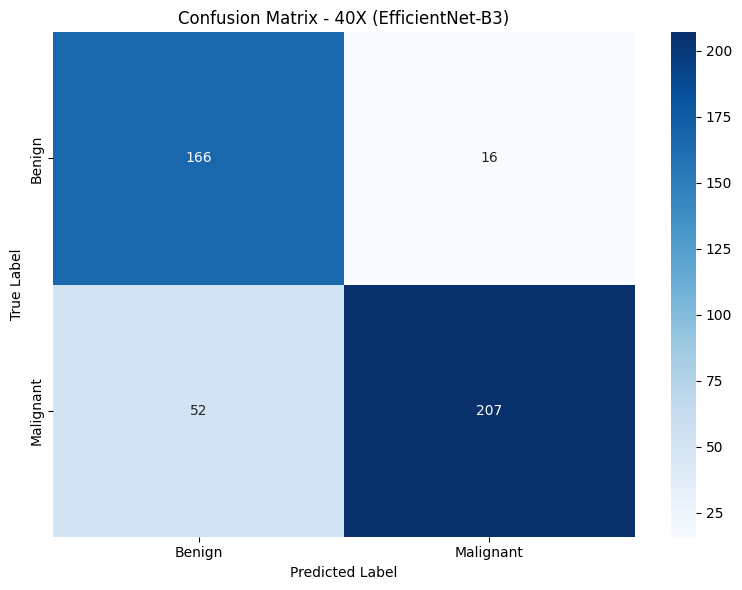


Starting experiment for 100X...

Training on 100X magnification with EfficientNet-B3

Phase 1: Training classifier head (frozen backbone)


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch   1: Train Loss: 0.6321, Val Loss: 0.6228, Val AUC: 0.8472


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


Epoch   2: Train Loss: 0.5599, Val Loss: 0.6521, Val AUC: 0.8456


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Epoch   3: Train Loss: 0.5312, Val Loss: 0.5662, Val AUC: 0.8302


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


Epoch   4: Train Loss: 0.5360, Val Loss: 0.6453, Val AUC: 0.8678


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


Epoch   5: Train Loss: 0.5329, Val Loss: 0.6016, Val AUC: 0.8655


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch   6: Train Loss: 0.5219, Val Loss: 0.6159, Val AUC: 0.8651


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


Epoch   7: Train Loss: 0.5159, Val Loss: 0.6073, Val AUC: 0.8692


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Epoch   8: Train Loss: 0.5034, Val Loss: 0.7107, Val AUC: 0.8473


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


Epoch   9: Train Loss: 0.5161, Val Loss: 0.6582, Val AUC: 0.8616


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


Epoch  10: Train Loss: 0.5011, Val Loss: 0.6127, Val AUC: 0.8363


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Epoch  11: Train Loss: 0.4989, Val Loss: 0.6615, Val AUC: 0.8395


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Epoch  12: Train Loss: 0.4927, Val Loss: 0.5989, Val AUC: 0.8708


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch  13: Train Loss: 0.5048, Val Loss: 0.6122, Val AUC: 0.8587


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


Epoch  14: Train Loss: 0.4949, Val Loss: 0.5579, Val AUC: 0.8420


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch  15: Train Loss: 0.4996, Val Loss: 0.5395, Val AUC: 0.8557


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Epoch  16: Train Loss: 0.5020, Val Loss: 0.5688, Val AUC: 0.8525


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


Epoch  17: Train Loss: 0.4795, Val Loss: 0.6078, Val AUC: 0.8229


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


Epoch  18: Train Loss: 0.4985, Val Loss: 0.5959, Val AUC: 0.8275


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]


Epoch  19: Train Loss: 0.4866, Val Loss: 0.5863, Val AUC: 0.8508


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Epoch  20: Train Loss: 0.4827, Val Loss: 0.6351, Val AUC: 0.8200


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Epoch  21: Train Loss: 0.4775, Val Loss: 0.5796, Val AUC: 0.8383


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]


Epoch  22: Train Loss: 0.4702, Val Loss: 0.5767, Val AUC: 0.8542
Early stopping at epoch 22

Phase 2: Fine-tuning with unfrozen last conv layers


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.06it/s]


Epoch   1: Train Loss: 0.4660, Val Loss: 0.5696, Val AUC: 0.8726


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


Epoch   2: Train Loss: 0.4456, Val Loss: 0.5801, Val AUC: 0.8676


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Epoch   3: Train Loss: 0.4349, Val Loss: 0.5609, Val AUC: 0.8745


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


Epoch   4: Train Loss: 0.4232, Val Loss: 0.5466, Val AUC: 0.8802


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]


Epoch   5: Train Loss: 0.4322, Val Loss: 0.5736, Val AUC: 0.8640


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


Epoch   6: Train Loss: 0.4269, Val Loss: 0.5544, Val AUC: 0.8796


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


Epoch   7: Train Loss: 0.4236, Val Loss: 0.5521, Val AUC: 0.8807


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Epoch   8: Train Loss: 0.4094, Val Loss: 0.5420, Val AUC: 0.8945


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Epoch   9: Train Loss: 0.4119, Val Loss: 0.5385, Val AUC: 0.8927


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


Epoch  10: Train Loss: 0.4151, Val Loss: 0.5233, Val AUC: 0.8980


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


Epoch  11: Train Loss: 0.4035, Val Loss: 0.5477, Val AUC: 0.9038


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


Epoch  12: Train Loss: 0.3983, Val Loss: 0.5316, Val AUC: 0.9076


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Epoch  13: Train Loss: 0.4026, Val Loss: 0.5200, Val AUC: 0.9044


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Epoch  14: Train Loss: 0.3925, Val Loss: 0.5186, Val AUC: 0.9145


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch  15: Train Loss: 0.3963, Val Loss: 0.5216, Val AUC: 0.9054


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


Epoch  16: Train Loss: 0.3874, Val Loss: 0.5118, Val AUC: 0.9147


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]


Epoch  17: Train Loss: 0.3843, Val Loss: 0.5271, Val AUC: 0.9092


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch  18: Train Loss: 0.3829, Val Loss: 0.5208, Val AUC: 0.9122


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]


Epoch  19: Train Loss: 0.3844, Val Loss: 0.5300, Val AUC: 0.9175


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.06it/s]


Epoch  20: Train Loss: 0.3774, Val Loss: 0.5239, Val AUC: 0.9190


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Epoch  21: Train Loss: 0.3845, Val Loss: 0.5270, Val AUC: 0.9165


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Epoch  22: Train Loss: 0.3775, Val Loss: 0.5114, Val AUC: 0.9188


Validation: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


Epoch  23: Train Loss: 0.3786, Val Loss: 0.5049, Val AUC: 0.9165


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Epoch  24: Train Loss: 0.3794, Val Loss: 0.5223, Val AUC: 0.9133


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]


Epoch  25: Train Loss: 0.3660, Val Loss: 0.5178, Val AUC: 0.9124


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]


Epoch  26: Train Loss: 0.3728, Val Loss: 0.5076, Val AUC: 0.9139


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]


Epoch  27: Train Loss: 0.3751, Val Loss: 0.5103, Val AUC: 0.9181


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Epoch  28: Train Loss: 0.3628, Val Loss: 0.5204, Val AUC: 0.9262


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


Epoch  29: Train Loss: 0.3591, Val Loss: 0.5138, Val AUC: 0.9132


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Epoch  30: Train Loss: 0.3629, Val Loss: 0.5169, Val AUC: 0.9165


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]


Epoch  31: Train Loss: 0.3725, Val Loss: 0.5170, Val AUC: 0.9186


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


Epoch  32: Train Loss: 0.3685, Val Loss: 0.5199, Val AUC: 0.9144


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch  33: Train Loss: 0.3732, Val Loss: 0.5295, Val AUC: 0.9100


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


Epoch  34: Train Loss: 0.3709, Val Loss: 0.5280, Val AUC: 0.8991


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Epoch  35: Train Loss: 0.3735, Val Loss: 0.5389, Val AUC: 0.9055


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch  36: Train Loss: 0.3652, Val Loss: 0.5251, Val AUC: 0.9049


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


Epoch  37: Train Loss: 0.3626, Val Loss: 0.5257, Val AUC: 0.8981


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.05it/s]


Epoch  38: Train Loss: 0.3629, Val Loss: 0.5323, Val AUC: 0.9036
Early stopping at epoch 38


Testing: 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]



Best validation AUC: 0.9262
Test metrics:
  accuracy: 0.8658
  precision: 0.9236
  recall: 0.8552
  specificity: 0.8833
  f1: 0.8881
  auc_roc: 0.9354


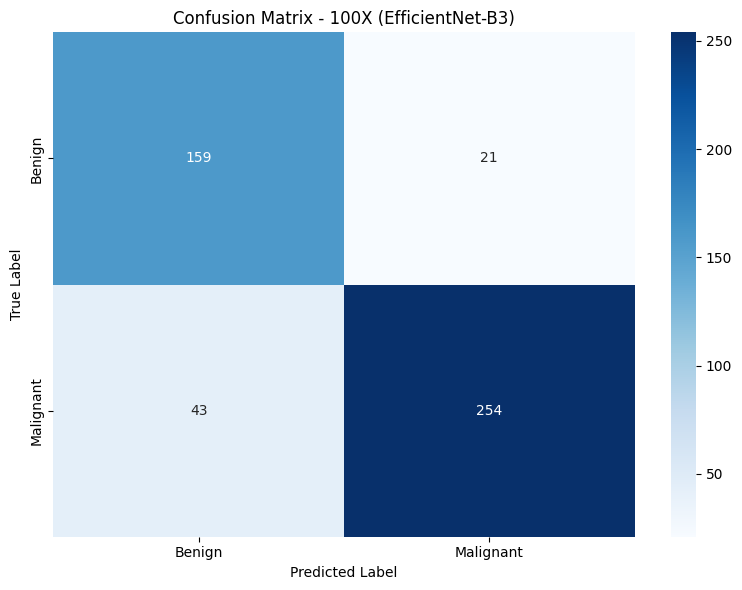


Starting experiment for 200X...

Training on 200X magnification with EfficientNet-B3

Phase 1: Training classifier head (frozen backbone)


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


Epoch   1: Train Loss: 0.6422, Val Loss: 0.6030, Val AUC: 0.8176


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.98it/s]


Epoch   2: Train Loss: 0.5604, Val Loss: 0.5849, Val AUC: 0.8504


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.98it/s]


Epoch   3: Train Loss: 0.5276, Val Loss: 0.5533, Val AUC: 0.8548


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]


Epoch   4: Train Loss: 0.5322, Val Loss: 0.5691, Val AUC: 0.8595


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.68it/s]


Epoch   5: Train Loss: 0.5262, Val Loss: 0.5995, Val AUC: 0.8349


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.98it/s]


Epoch   6: Train Loss: 0.5125, Val Loss: 0.6005, Val AUC: 0.8560


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.01it/s]


Epoch   7: Train Loss: 0.5048, Val Loss: 0.5479, Val AUC: 0.8706


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.70it/s]


Epoch   8: Train Loss: 0.5103, Val Loss: 0.5539, Val AUC: 0.8669


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.01it/s]


Epoch   9: Train Loss: 0.5043, Val Loss: 0.5380, Val AUC: 0.8606


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


Epoch  10: Train Loss: 0.4951, Val Loss: 0.6352, Val AUC: 0.8328


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.67it/s]


Epoch  11: Train Loss: 0.4961, Val Loss: 0.5570, Val AUC: 0.8366


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]


Epoch  12: Train Loss: 0.4922, Val Loss: 0.6613, Val AUC: 0.8563


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.01it/s]


Epoch  13: Train Loss: 0.5079, Val Loss: 0.5686, Val AUC: 0.8469


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.69it/s]


Epoch  14: Train Loss: 0.4760, Val Loss: 0.5786, Val AUC: 0.8544


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.68it/s]


Epoch  15: Train Loss: 0.4721, Val Loss: 0.5940, Val AUC: 0.8626


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


Epoch  16: Train Loss: 0.4827, Val Loss: 0.5506, Val AUC: 0.8518


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


Epoch  17: Train Loss: 0.4825, Val Loss: 0.5772, Val AUC: 0.8468
Early stopping at epoch 17

Phase 2: Fine-tuning with unfrozen last conv layers


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.68it/s]


Epoch   1: Train Loss: 0.4719, Val Loss: 0.5512, Val AUC: 0.8714


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Epoch   2: Train Loss: 0.4567, Val Loss: 0.5472, Val AUC: 0.8770


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


Epoch   3: Train Loss: 0.4648, Val Loss: 0.5596, Val AUC: 0.8658


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]


Epoch   4: Train Loss: 0.4467, Val Loss: 0.5442, Val AUC: 0.8684


Validation: 100%|██████████| 12/12 [00:06<00:00,  2.00it/s]


Epoch   5: Train Loss: 0.4340, Val Loss: 0.5212, Val AUC: 0.9049


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Epoch   6: Train Loss: 0.4380, Val Loss: 0.5346, Val AUC: 0.9090


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Epoch   7: Train Loss: 0.4212, Val Loss: 0.5104, Val AUC: 0.9149


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Epoch   8: Train Loss: 0.4245, Val Loss: 0.5029, Val AUC: 0.9177


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Epoch   9: Train Loss: 0.4240, Val Loss: 0.4918, Val AUC: 0.9190


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Epoch  10: Train Loss: 0.4181, Val Loss: 0.5133, Val AUC: 0.9217


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


Epoch  11: Train Loss: 0.4220, Val Loss: 0.4921, Val AUC: 0.9286


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.00it/s]


Epoch  12: Train Loss: 0.4080, Val Loss: 0.5011, Val AUC: 0.9092


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.05it/s]


Epoch  13: Train Loss: 0.4090, Val Loss: 0.5014, Val AUC: 0.9034


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Epoch  14: Train Loss: 0.4043, Val Loss: 0.5078, Val AUC: 0.9075


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Epoch  15: Train Loss: 0.4016, Val Loss: 0.5027, Val AUC: 0.9076


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Epoch  16: Train Loss: 0.4017, Val Loss: 0.5034, Val AUC: 0.9153


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch  17: Train Loss: 0.3948, Val Loss: 0.5009, Val AUC: 0.9168


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.68it/s]


Epoch  18: Train Loss: 0.4045, Val Loss: 0.4888, Val AUC: 0.9206


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.01it/s]


Epoch  19: Train Loss: 0.4036, Val Loss: 0.4979, Val AUC: 0.9265


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.01it/s]


Epoch  20: Train Loss: 0.3879, Val Loss: 0.4824, Val AUC: 0.9297


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


Epoch  21: Train Loss: 0.3755, Val Loss: 0.5114, Val AUC: 0.9235


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch  22: Train Loss: 0.3935, Val Loss: 0.4907, Val AUC: 0.9318


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.98it/s]


Epoch  23: Train Loss: 0.3856, Val Loss: 0.4847, Val AUC: 0.9303


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


Epoch  24: Train Loss: 0.3828, Val Loss: 0.4828, Val AUC: 0.9312


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.70it/s]


Epoch  25: Train Loss: 0.3808, Val Loss: 0.5084, Val AUC: 0.9198


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


Epoch  26: Train Loss: 0.3955, Val Loss: 0.5164, Val AUC: 0.9155


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.00it/s]


Epoch  27: Train Loss: 0.3955, Val Loss: 0.4937, Val AUC: 0.9097


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.70it/s]


Epoch  28: Train Loss: 0.3712, Val Loss: 0.5076, Val AUC: 0.9097


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]


Epoch  29: Train Loss: 0.3747, Val Loss: 0.5147, Val AUC: 0.8934


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.00it/s]


Epoch  30: Train Loss: 0.3787, Val Loss: 0.4882, Val AUC: 0.9152


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


Epoch  31: Train Loss: 0.3760, Val Loss: 0.4910, Val AUC: 0.9142


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]


Epoch  32: Train Loss: 0.3830, Val Loss: 0.5005, Val AUC: 0.9119
Early stopping at epoch 32


Testing: 100%|██████████| 14/14 [00:07<00:00,  1.92it/s]



Best validation AUC: 0.9318
Test metrics:
  accuracy: 0.7765
  precision: 0.8480
  recall: 0.7766
  specificity: 0.7765
  f1: 0.8107
  auc_roc: 0.8407


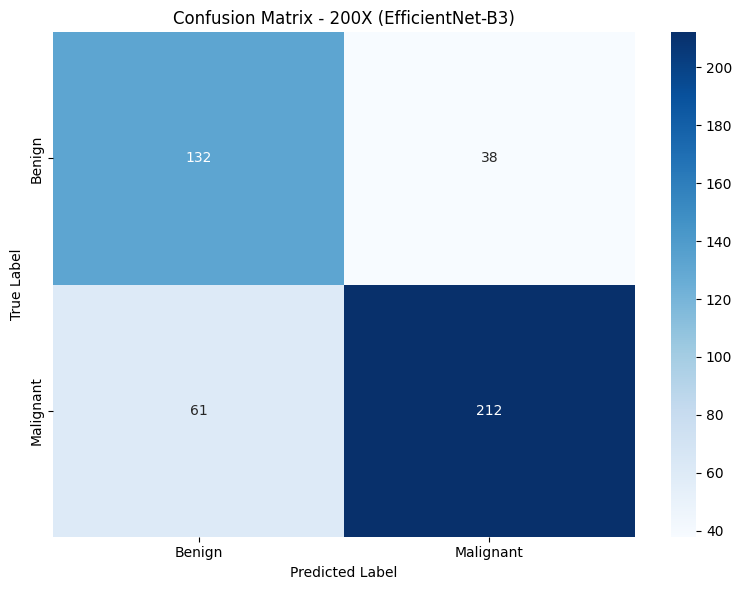


Starting experiment for 400X...

Training on 400X magnification with EfficientNet-B3

Phase 1: Training classifier head (frozen backbone)


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Epoch   1: Train Loss: 0.6537, Val Loss: 0.6248, Val AUC: 0.8775


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Epoch   2: Train Loss: 0.5918, Val Loss: 0.6034, Val AUC: 0.8800


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Epoch   3: Train Loss: 0.5657, Val Loss: 0.5723, Val AUC: 0.8961


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Epoch   4: Train Loss: 0.5743, Val Loss: 0.5565, Val AUC: 0.8905


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]


Epoch   5: Train Loss: 0.5621, Val Loss: 0.6038, Val AUC: 0.9167


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]


Epoch   6: Train Loss: 0.5366, Val Loss: 0.6049, Val AUC: 0.9216


Training:  12%|█▏        | 4/34 [00:03<00:16,  1.78it/s]

In [ ]:
if __name__ == "__main__":
    results = main()